In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
#%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [2]:
pip install numpy==1.19.2

Note: you may need to restart the kernel to use updated packages.


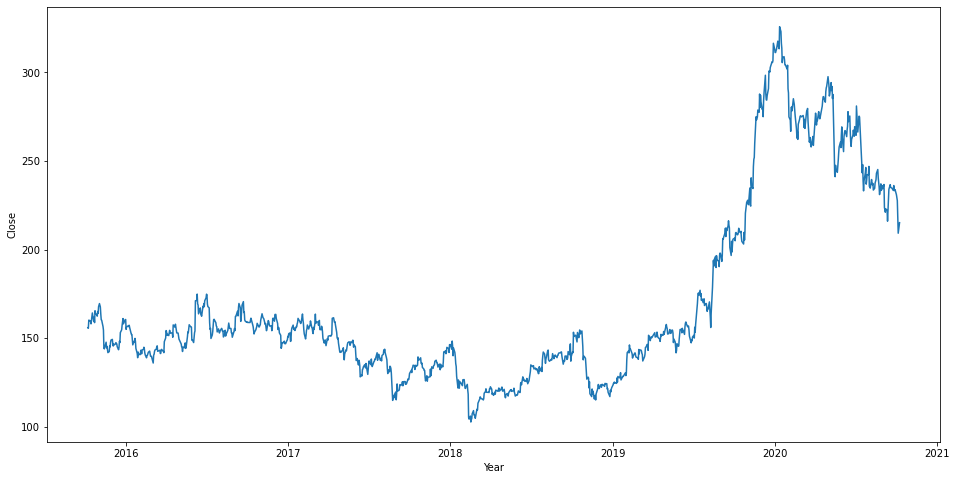

In [3]:
df=pd.read_csv("NSE-TATA.csv")
df.head()

df["Date"]=pd.to_datetime(df.Date,format="%m/%d/%y")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.ylabel('Close')
plt.xlabel('Year')
plt.plot(df["Close"],label='Close Price history')

In [4]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]
    

new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

In [5]:
final_dataset=new_dataset.values

train_data=final_dataset[0:500,:]
valid_data=final_dataset[500:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))



In [6]:

lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

440/440 - 23s - loss: 0.0014


<ipython-input-7-e6ae107d99f7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=closing_price


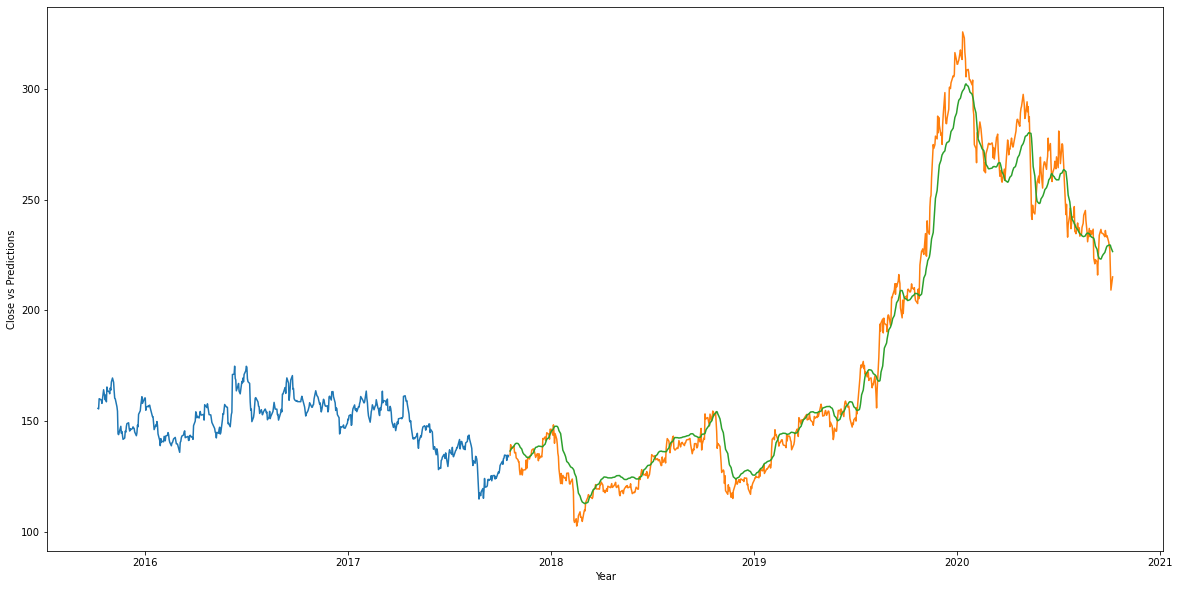

In [7]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price=lstm_model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

lstm_model.save("saved_lstm_model.h5")

train_data=new_dataset[:500]
valid_data=new_dataset[500:]
valid_data['Predictions']=closing_price
plt.ylabel('Close vs Predictions')
plt.xlabel('Year')
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])
